In [20]:
from dataset.dataset import * 
from model.gru import GRU
from utils.loss import max_sharpe 
from utils.optimizer import SAM 
from utils.utils import save_model, remove_prefix, load_model
import torch 
import torch.nn as nn 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pickle

In [21]:
dic = ["aapl", "pdd", "tsla", "meta", "jpm", "amd", "ngg", "biib", "ba", "ryaay"]
in_path="data/stocks/"
out_path="data/"
for i, ticker in enumerate(dic):
    stock = in_path + f"{ticker}.csv"
    stock_df = pd.read_csv(stock, index_col="Date")[["Adj Close"]]
    if i == 0:
        return_df = stock_df.pct_change()
        return_df.columns = [ticker]
    else:
        return_df[ticker] = stock_df.pct_change()
return_df = return_df.dropna()
return_df

,aapl,pdd,tsla,meta,jpm,amd,ngg,biib,ba,ryaay
Date,,,,,,,,,,
2022-01-04,-0.012692,-0.111943,-0.041833,-0.005937,0.037910,-0.038738,0.001936,-0.009871,0.027759,0.024521
2022-01-05,-0.026600,-0.025893,-0.053471,-0.036728,-0.018282,-0.057264,-0.009662,-0.010177,-0.002621,0.011004
2022-01-06,-0.016693,0.074181,-0.021523,0.025573,0.010624,0.000588,-0.010035,-0.008233,-0.008119,0.012245
2022-01-07,0.000988,0.072319,-0.035447,-0.002015,0.009908,-0.031050,0.008166,-0.019806,0.019684,0.039337
2022-01-10,0.000116,0.019499,0.030342,-0.011212,0.000957,0.000000,-0.000978,0.011651,-0.028724,-0.000172
...,...,...,...,...,...,...,...,...,...,...
2022-10-24,0.014803,-0.246057,-0.014876,-0.002231,0.001227,-0.002040,0.021022,0.026156,0.005166,0.000315
2022-10-25,0.019338,0.069051,0.052876,0.060052,0.002615,0.047189,0.033288,-0.003860,0.032383,0.028535
2022-10-26,-0.019627,0.116979,0.009981,-0.055923,0.011491,-0.028307,0.001676,0.025113,-0.087692,0.031116


In [28]:
return_df = return_df[return_df.index < '2022-10-01']
x_tr, y_tr, x_te, y_te, times_tr, times_te = data_split(
        return_df,
        50,
        10,
        '2022-08-01',
        10,
    )

path = "data/"
with open(path + "date.pkl", "wb") as f:
    pickle.dump(times_te, f)
with open(path + "dataset.pkl", "wb") as f:
    pickle.dump([x_tr, y_tr, x_te, y_te], f)

# Train

In [29]:
class GRU_CFG:
    n_layers = 1
    n_stocks = 10 
    hidden_dim = 128 
    bidirectional = False
    dropout = 0.2
    lb = 0
    ub = 1
    

In [30]:
### dataset 
with open("data/dataset.pkl", "rb") as f:
    train_x_raw, train_y_raw, test_x_raw, test_y_raw = pickle.load(f)

with open("data/date.pkl", "rb") as f:
    test_date = pickle.load(f)
train_x_raw = train_x_raw
train_y_raw = train_y_raw
test_x_raw = test_x_raw
test_y_raw = test_y_raw
test_date = test_date

# convert to tensor
train_x = torch.from_numpy(train_x_raw.astype("float32"))
train_y = torch.from_numpy(train_y_raw.astype("float32"))
test_x = torch.from_numpy(test_x_raw.astype("float32"))
test_y = torch.from_numpy(test_y_raw.astype("float32"))

# train dataset 
train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
test_dataset = torch.utils.data.TensorDataset(test_x, test_y)

# train dataloder
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size= 16, shuffle = False, drop_last = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = 4, shuffle = False, drop_last = False)

In [31]:
### models
# parameters
LEN_TRAIN = train_x.shape[1]
LEN_PRED = test_x.shape[1]
N_STOCK = 10
LR = 0.1
MOMENTUM = 0.9 
N_EPOCH = 500
EARLY_STOP = 20

# model 
gru_cfg = GRU_CFG()
model = GRU(gru_cfg)
model.cuda()

# criterion and optimizer
base_optimizer = torch.optim.SGD
optimizer = SAM(
    model.parameters(), base_optimizer, lr = LR, momentum = MOMENTUM 
)

criterion = max_sharpe 

In [32]:
# train
train_loss = []
valid_loss = []

early_stop_cnt = 0
for epoch in range(N_EPOCH):
#     if epoch != 0 and epoch % 5 == 0:     
#         print("Epoch {}/{}, training_loss:{}, testing_loss:{}".format(epoch + 1, N_EPOCH, train_loss[-1], valid_loss[-1]))
#         print("-" * 10)
        
    for mode in ["train",'valid']:
        if mode == 'train':
            model.train()
            dataloader = train_loader 
        else:
            model.eval()
            dataloader = test_loader
        running_loss = 0. 
        for idx, batch in enumerate(dataloader):
            x, y = batch 
            x = x.to("cuda")
            y = y.to("cuda")
            optimizer.zero_grad()
            with torch.set_grad_enabled(mode == "train"):
                out = model(x)
                loss = criterion(y, out)
                if mode == 'train':
                    loss.backward()
                    optimizer.first_step(zero_grad = True)
                    criterion(y, model(x)).backward()
                    optimizer.second_step(zero_grad = True) 
            running_loss += loss.item() / len(dataloader)
        if mode == 'train':
            train_loss.append(running_loss)
        else:
            valid_loss.append(running_loss)
            if running_loss <= min(valid_loss):
                save_model(model, "result", "hb")
                print(f"Improved! at {epoch + 1} epochs, with {running_loss}")
                early_stop_cnt = 0
            else:
                early_stop_cnt += 1
    if early_stop_cnt == EARLY_STOP:
        break

Improved! at 1 epochs, with 0.13025150199731192
Improved! at 2 epochs, with 0.12766894242829746
Improved! at 3 epochs, with 0.12414570028583208
Improved! at 4 epochs, with 0.11973882880475786
Improved! at 5 epochs, with 0.11441042822682196
Improved! at 6 epochs, with 0.10808051719019811
Improved! at 7 epochs, with 0.10064231138676405
Improved! at 8 epochs, with 0.09163118940260676
Improved! at 9 epochs, with 0.08026933131946458
Improved! at 10 epochs, with 0.06601058567563693
Improved! at 11 epochs, with 0.04746041529708438
Improved! at 12 epochs, with 0.022290023664633438
Improved! at 13 epochs, with -0.010073989629745497
Improved! at 14 epochs, with -0.044606923229164555
Improved! at 15 epochs, with -0.06968285308943853
Improved! at 16 epochs, with -0.08108822918600507
Improved! at 17 epochs, with -0.0848009826408492
Improved! at 18 epochs, with -0.08581135753128265
Improved! at 19 epochs, with -0.08606121150983705
Improved! at 20 epochs, with -0.08611059685548146


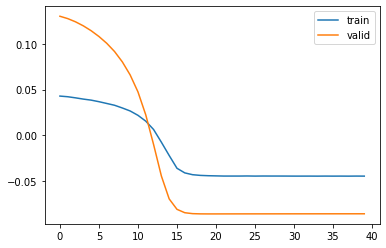

In [33]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label="train")
plt.plot(valid_loss, label="valid")
plt.legend(loc="upper right")
plt.show()

In [54]:
# Simulation

In [54]:
def generate_random(k):
    for time in range(k):
        randomPortfolio = [10000]
        randomWeights = np.random.dirichlet(np.ones(10))
        for i in range(0, test_x.shape[0], 10):
            x = test_x[i][np.newaxis, :, :]
            m_rtn = np.sum(test_y_raw[i], axis=0)
            randomPortfolio.append(
                randomPortfolio[-1] * np.exp(np.dot(randomWeights, m_rtn))
            )
        if time == 1:
            plt.plot(randomPortfolio, color = 'green', label = 'Random')
        else:
            plt.plot(randomPortfolio, color = 'green')
    

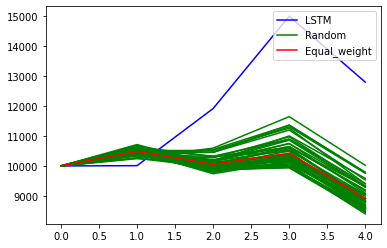

In [59]:
model = load_model(model, "result/best_model_weight_hb.pt", use_cuda=True)
myPortfolio, equalPortfolio = [10000], [10000]
EWPWeights = np.ones(N_STOCK) / N_STOCK
myWeights = []
for i in range(0, test_x.shape[0], 10):
    x = test_x[i][np.newaxis, :, :]
    out = model(x.float().cuda())[0]
    myWeights.append(out.detach().cpu().numpy())
    m_rtn = np.sum(test_y_raw[i], axis=0)
    myPortfolio.append(
        myPortfolio[-1] * np.exp(np.dot(out.detach().cpu().numpy(), m_rtn))
    )
    equalPortfolio.append(
        equalPortfolio[-1] * np.exp(np.dot(EWPWeights, m_rtn))
    )
plt.plot(myPortfolio,color = 'blue', label = 'LSTM')
generate_random(50)
plt.plot(equalPortfolio, color = 'red',label = 'Equal_weight')
plt.legend(loc="upper right")